# Plotting ACCESS output practice

Example of how to plot the temperature from model output of ACCESS model.

(Method can be easily adopted to other resolutions.)

## From file of barotropic streamfunction

In [8]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

## From file of Cross-slope section

In [9]:
# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation 
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm

# Load metpy module to obtain cross section 
# (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

In [10]:
client = Client(n_workers=4)

Start a session in the default COSIMA database. To search this database, the following commands can be used:

e.g.: search for all the `1deg` experiments

```python
exp = cc.querying.get_experiments(session)
exp[exp['experiment'].str.lower().str.match('1deg')]
```

In [11]:
# Load database
session = cc.database.create_session()

In [12]:
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

Additional information: The model grid is an Arakawa B-grid, which means that the tracers (such as temperature and salinity) are located at the middle of the cell. The velocities are located at the top right corner of a cell. The latitude and longitude information varies therefore for the tracers and the velocities. So when you load in temperature for example, you refer to the latitude by 'yt_ocean', whereas for the velocity by 'yu_ocean'.
Similar, when you load in the bathymetry information, there are two versions, one for each point on the grid. 'ht' is the bathymetry on the tracer grid (t-grid) and 'hu' is the bathymetry on the momentum grid (u-grid).

In [13]:
# Time information
start_time = '2080-01-01'
end_time = '2080-12-31'

### Select and calculate temp vars

In [14]:
# Latitude range (pan-Antarctic)
lat_min = -80
lat_max = -60

# Import temperature, convert to degree Celsius
temp = cc.querying.getvar(expt=expt, variable='temp', session=session, start_time=start_time, end_time=end_time, frequency='1 monthly') - 273.15

# Select latitude range:
temp = temp.sel(yt_ocean = slice(lat_min, lat_max))

# Calculating annual average:
temp = temp.mean('time')

# Select surface ocean:
temp_surface = temp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m    = temp.sel(st_ocean=250, method='nearest')

temp_surface

ValueError: Couldn't parse datetime string: '2020-06-11'

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 559, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140565342992192 and this is thread id 140563189614336.
Exception closing connection <sqlite3.Connection object at 0x7fd768150300>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/sqlalchemy/

### Complete Southern Ocean

First, we want to make a map of Southern Ocean, the example is in file of barotropic streamfunction of cosima-recipes.

Text(0.5, 1.0, 'Surface temperature of Southern Ocean from -80N to -60N [C]')

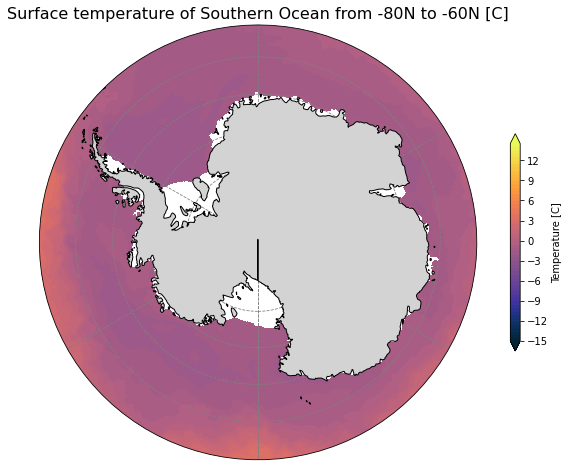

In [8]:
# Define the levels for the contourf
lvls = np.arange(-15, 15, 0.5)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the surface ocean temperature
cf = ax.contourf(temp_surface['xt_ocean'], temp_surface['yt_ocean'], temp_surface, levels = lvls, cmap = cm.cm.thermal, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Temperature [C]')

plt.title('Surface temperature of Southern Ocean from -80N to -60N [C]', fontsize=16)

Text(0.5, 1.0, '250m depth temperature of Southern Ocean from -80N to -60N [C]')

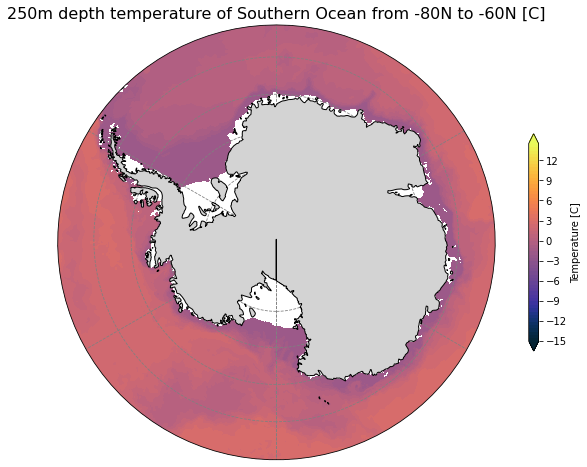

In [62]:
# Define the levels for the contourf
lvls = np.arange(-15, 15, 0.5)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the surface ocean temperature
cf = ax.contourf(temp_250m['xt_ocean'], temp_250m['yt_ocean'], temp_250m, levels = lvls, cmap = cm.cm.thermal, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Temperature [C]')

plt.title('250m depth temperature of Southern Ocean from -80N to -60N [C]', fontsize=16)

### Region of the Southern Ocean

Second, we want to make a map of a region in Southern Ocean, the example is in file of barotropic streamfunction of cosima-recipes.

Text(0.5, 1.0, 'Surface temperature of a region from -60E to 60E [C]')

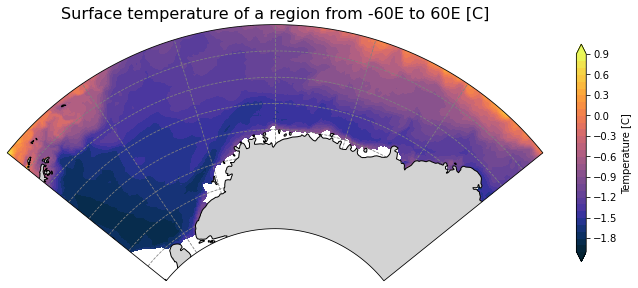

In [13]:
# Select the region in the variables from -60E to 60E
temp_re_surface = temp_surface.sel(xt_ocean = slice(-60, 60))

# Define the levels for the contourf
lvls = np.arange(-2, 1, 0.1)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.AlbersEqualArea(central_longitude = 0, central_latitude = -62.5, standard_parallels = (-70, -50)))
ax.set_extent([-60, 60, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to the lat, lon boundaries
vertices = [(lon, -80) for lon in range(-60, 60+1, 1)] + [(lon, -60) for lon in range(60, -60-1, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the surface ocean temperature
cf = ax.contourf(temp_re_surface['xt_ocean'], temp_re_surface['yt_ocean'], temp_re_surface, levels = lvls, cmap = cm.cm.thermal, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Temperature [C]')

plt.title('Surface temperature of a region from -60E to 60E [C]', fontsize=16)

Text(0.5, 1.0, '250m depth temperature of a region from -60E to 60E [C]')

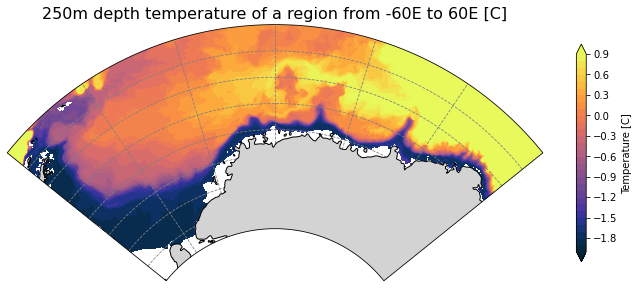

In [14]:
# Select the region in the variables from -60E to 60E
temp_re_250m = temp_250m.sel(xt_ocean = slice(-60, 60))

# Define the levels for the contourf
lvls = np.arange(-2, 1, 0.1)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.AlbersEqualArea(central_longitude = 0, central_latitude = -62.5, standard_parallels = (-70, -50)))
ax.set_extent([-60, 60, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to the lat, lon boundaries
vertices = [(lon, -80) for lon in range(-60, 60+1, 1)] + [(lon, -60) for lon in range(60, -60-1, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the surface ocean temperature
cf = ax.contourf(temp_re_250m['xt_ocean'], temp_re_250m['yt_ocean'], temp_re_250m, levels = lvls, cmap = cm.cm.thermal, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Temperature [C]')

plt.title('250m depth temperature of a region from -60E to 60E [C]', fontsize=16)

### Cross-slope section of temperature

Third, we want to make a transect of temperature in a certain longitude, the example is in file of Cross-slope section of cosima-recipes.

Text(0.5, 1.0, 'Selected transects at different longitude')

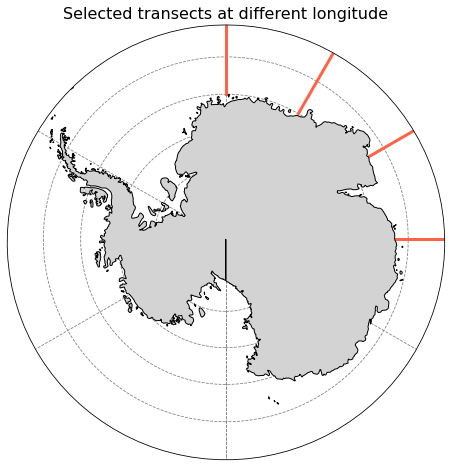

In [126]:
# Define the levels for the contourf
lvls = np.arange(-15, 15, 0.5)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot location of cross-slope section (East Antarctica)
plt.plot([0, 0], [-70, -60], color='tomato', linewidth=3, transform=ccrs.PlateCarree())
plt.plot([30, 30], [-70, -60], color='tomato', linewidth=3, transform=ccrs.PlateCarree())
plt.plot([60, 60], [-70, -60], color='tomato', linewidth=3, transform=ccrs.PlateCarree())
plt.plot([90, 90], [-70, -60], color='tomato', linewidth=3, transform=ccrs.PlateCarree())

plt.title('Selected transects at different longitude', fontsize=16)

Text(0, 0.5, 'Depth (m)')

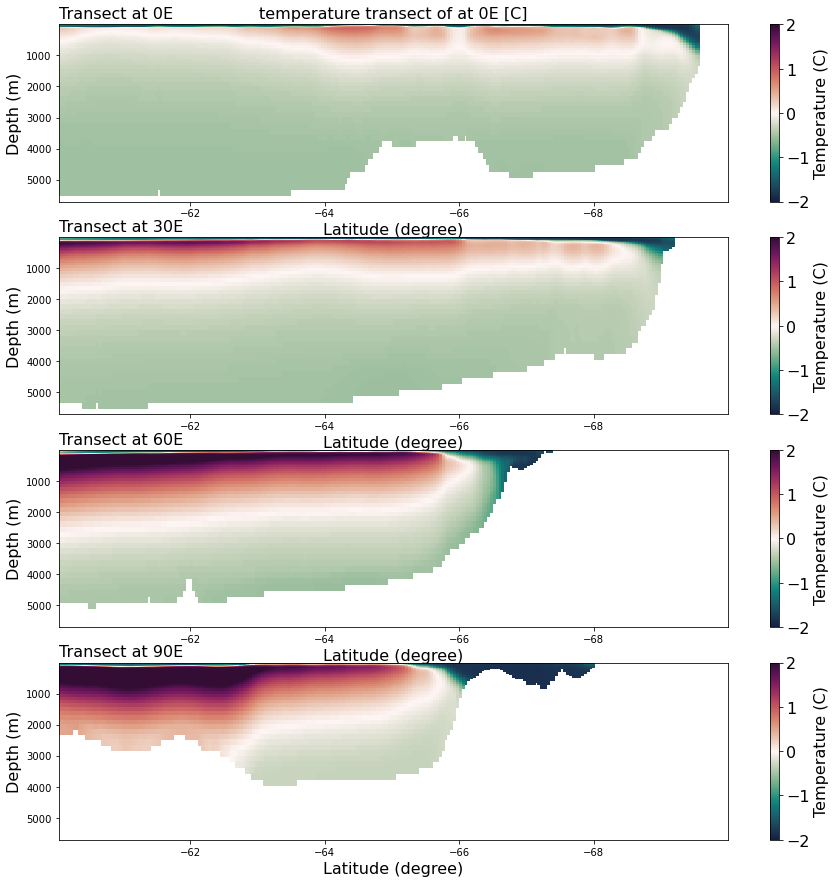

In [21]:
# Select transect, e.g. at prime meridian:
temp_prime_meridian = temp.sel(xt_ocean=0, method='nearest')

# Select the region in the variables from -70N to -60N
temp_prime_meridian = temp_prime_meridian.sel(yt_ocean = slice(-70, -60))

# Select transect
temp_30 = temp.sel(xt_ocean=30, method='nearest')
temp_60 = temp.sel(xt_ocean=60, method='nearest')
temp_90 = temp.sel(xt_ocean=90, method='nearest')

# Select transect from -70N to -60N
temp_30 = temp_30.sel(yt_ocean = slice(-70, -60))
temp_60 = temp_60.sel(yt_ocean = slice(-70, -60))
temp_90 = temp_90.sel(yt_ocean = slice(-70, -60))

ft_size=16
fig = plt.figure(figsize=(15, 15))

plt.subplot(4,1,1)
plt.title('Transect at 0E', fontsize=ft_size, loc='left')
plt.pcolormesh(temp_prime_meridian['yt_ocean'], temp_prime_meridian['st_ocean'], temp_prime_meridian, cmap=cm.cm.curl, vmin=-2, vmax=2) 
#'curl' can be swapped with 'thermal'
# Colorbar
cbar = plt.colorbar()
cbar.set_label('Temperature (C)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)
# Axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Latitude (degree)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.title('temperature transect of at 0E [C]', fontsize=16)

plt.subplot(4,1,2)
plt.title('Transect at 30E', fontsize=ft_size, loc='left')
plt.pcolormesh(temp_30['yt_ocean'], temp_30['st_ocean'], temp_30, cmap=cm.cm.curl, vmin=-2, vmax=2)
# Colorbar
cbar = plt.colorbar()
cbar.set_label('Temperature (C)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)
# Axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Latitude (degree)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.subplot(4,1,3)
plt.title('Transect at 60E', fontsize=ft_size, loc='left')
plt.pcolormesh(temp_60['yt_ocean'], temp_60['st_ocean'], temp_60, cmap=cm.cm.curl, vmin=-2, vmax=2)
# Colorbar
cbar = plt.colorbar()
cbar.set_label('Temperature (C)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)
# Axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Latitude (degree)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.subplot(4,1,4)
plt.title('Transect at 90E', fontsize=ft_size, loc='left')
plt.pcolormesh(temp_90['yt_ocean'], temp_90['st_ocean'], temp_90, cmap=cm.cm.curl, vmin=-2, vmax=2)
# Colorbar
cbar = plt.colorbar()
cbar.set_label('Temperature (C)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)
# Axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Latitude (degree)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)